<h1><center style="font-size: 48px">Manipulate Healpix maps</center></h1>
<br><br>

In [1]:
from __future__ import division
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from astropy.table import Table
import os
import argparse
import ast
from reproject import reproject_from_healpix, reproject_to_healpix

## From 2D catalogue to Healpix map

## 1- Load 2D data

In [2]:
data=np.loadtxt('2d_catalogue.dat')
data2d=np.column_stack((data[:,0],data[:,1]))

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


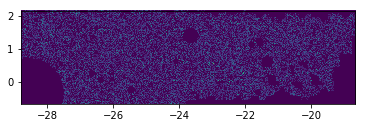

In [4]:
plt.hist2d(data2d[:,0],data2d[:,1],1024);
plt.gca().set_aspect('equal')

In [5]:
radec = data2d
#(max(radec[:,0])+min(radec[:,0]))/2,(max(radec[:,1])+min(radec[:,1]))/2

## 2- Create Healpix map

In [6]:
nside=4096
nest=False
npix = hp.nside2npix(nside)

In [7]:
theta = np.deg2rad(90.0 - radec[:, 1])

In [8]:
phi = np.deg2rad(radec[:, 0])

In [9]:
#  theta_g, phi_g = hp.Rotator(coord='cg')(theta, phi)

In [10]:
gal_hppix = hp.ang2pix(nside, theta=theta, phi=phi, nest=nest)

In [11]:
weights=None

In [16]:
countmap = np.bincount(gal_hppix, weights=weights, minlength=npix)

(array([1.0480e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.2120e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.9510e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.1519e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.5060e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.6498e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.5737e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.3572e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0231e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.0550e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.5790e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.6490e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.4770e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.9000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.8700e+02, 0.0000e+00, 0.0000e+00, 0.00

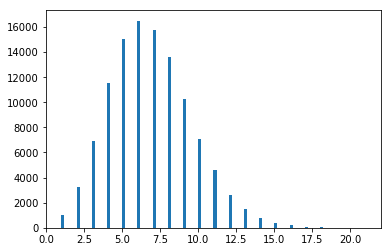

In [17]:
np.where(countmap != 0)
plt.hist(countmap[np.where(countmap != 0)],bins=100)

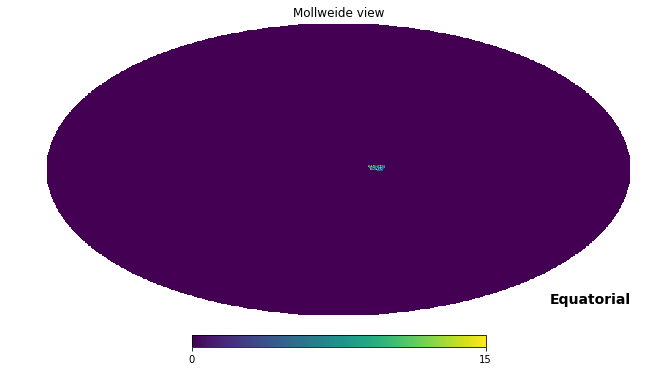

In [19]:
hp.mollview(countmap,coord='C')

## 3- write healpix image

In [63]:
hp.write_map('testmap.fits', countmap,fits_IDL=False,coord='C')

## 4- read healpix images

In [64]:
my_data = hp.read_map("testmap.fits")

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


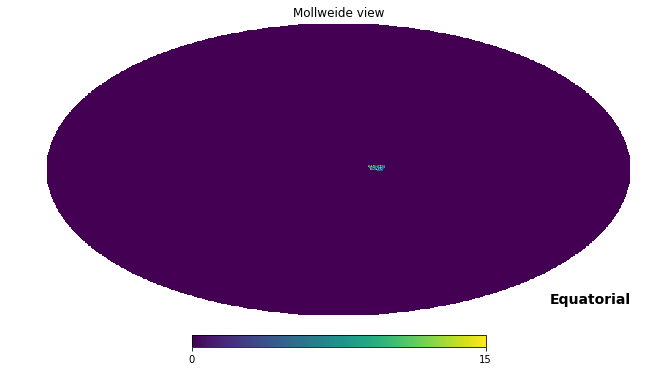

In [65]:
hp.mollview(my_data,coord='C')

##  From healpix map to local projected map

## 1- Define the WCS header for projection
I picked a central RA,dec position at CRVAL1  =  336.256 /
CRVAL2  =  0.74382 /
which is about the center of the 2D catalogue.

In [20]:
target_header = fits.Header.fromstring("""
SIMPLE  =                    T / Written by IDL:  Thu Apr  6 12:23:51 2017
BITPIX  =                  -32 / Number of bits per data pixel
NAXIS   =                    2 / Number of data axes
NAXIS1  =                  2100 /
NAXIS2  =                  600 /
DATE    = '2017-04-06'         / Creation UTC (CCCC-MM-DD) date of FITS header
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H
EXTEND  =                    T /
CTYPE1  = 'RA---TAN          ' /
CTYPE2  = 'DEC--TAN          ' /
CRPIX1  =              1050.000 /
CRPIX2  =              300.000 /
CD1_1   =           0.00500000 /
CD2_2   =           0.00500000 /
CD2_1   =              0.00000 /
CD1_2   =              0.00000 /
CRVAL1  =              336.256 /
CRVAL2  =              0.74382 /
RADECSYS= 'FK5               ' /
EQUINOX =              2000.00 /
END
""", sep='\n')

In [21]:
from astropy import wcs

In [22]:
wcs = wcs.WCS(target_header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## 2- Define 2D template of fits file

In [23]:
nx,ny=2100,600
x_idx = np.arange(nx)
y_idx = np.arange(ny)

(600, 2100)

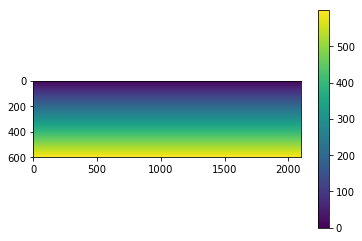

In [24]:
x_idx_grid, y_idx_grid = np.meshgrid(x_idx, y_idx)
plt.imshow(y_idx_grid)
plt.colorbar()
y_idx_grid.shape

In [25]:
coords = wcs.wcs_pix2world(np.vstack((x_idx_grid.flatten('F'), y_idx_grid.flatten('F'))).T, 0)
coords.shape

(1260000, 2)

In [26]:
ra_flat = coords[:,0]
dec_flat = coords[:,1]

In [27]:
theta_rad = np.deg2rad(90.0 - dec_flat)
phi_rad = np.deg2rad(ra_flat)

## 3- Calculate the corresponding pixels in the Healpix map

In [28]:
npix=hp.ang2pix(nside,theta_rad, phi_rad)

In [34]:
bb=countmap[npix].reshape((nx,ny))

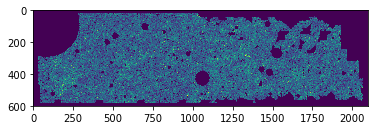

In [35]:
plt.imshow(bb.T)

### You can visualise this fits image with ds9

In [36]:
outfile='maskcut.fits'
#bb[where(bb > 0)]=1
hduout = fits.PrimaryHDU(bb.T,header=target_header)
hduout.writeto(outfile, clobber=True)